In [1]:
import sys
import os

# 获取当前工作目录（Jupyter Notebook 的启动目录）
_proj_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
_proj_root = os.path.normpath(_proj_root)
if _proj_root not in sys.path:
    sys.path.insert(0, _proj_root)

import HydroSynth.utils.utils as utils

import torch
import xarray
import numpy as np
import random
import torch
import config
from eofs.standard import Eof
import observe_norm
import os
%load_ext autoreload
%autoreload 1
# %aimport utils
%aimport config

In [2]:


HDF5_USE_FILE_LOCKING=False

data_all = []
file_name_list = utils.read_nc_to_npy(199401,202409)
print('总计月份：', len(file_name_list))
for f in file_name_list:
    try:
        selected_data = xarray.open_dataset(f)[['tp', 'h500', 'slp', 't2m', 't850', 'u850', 'v850']].sel(longitude=slice(70, 140), latitude=slice(60, 0))
        nth_data = selected_data.isel(time=0)
        data_all.append(nth_data.to_array().to_numpy())
    except Exception as e:
        print(f"处理文件 {f} 时出现错误: {e}, 跳过该文件。")
all_dataset = np.stack(data_all)  # 366,6,10,120,140

np_data = all_dataset#.transpose(1, 0, 2, 3)
torch_tensor = torch.from_numpy(np_data)
print(f"转换后的 torch.Tensor 形状: {torch_tensor.shape}")


scale_factor = 2
lr_data = torch_tensor
# 合并前两个维度 (366, 10, 6, 60, 70) -> (3660, 6, 60, 70)
# reshaped_tensor = torch_tensor.reshape(-1, *torch_tensor.shape[2:])

# 进行插值
lr_data = torch.nn.functional.interpolate(
    torch_tensor, 
    scale_factor=scale_factor, 
    mode='bicubic'
)

# # 恢复原始形状
# lr_data = lr_data.reshape(torch_tensor.shape[0], torch_tensor.shape[1], 
#                          torch_tensor.shape[2], 
#                          int(torch_tensor.shape[3] * scale_factor), 
#                          int(torch_tensor.shape[4] * scale_factor))
# lr_data = lr_data * 31*24*60*60*1000


print(lr_data.shape)
print('done')

total month 369
总计月份： 369
处理文件 E:\D1\data\MODESv21_ecmwf_seas51\MODESv21_ecmwf_seas51_201109_monthly_em.nc 时出现错误: [Errno -101] NetCDF: HDF error: 'E:\\D1\\data\\MODESv21_ecmwf_seas51\\MODESv21_ecmwf_seas51_201109_monthly_em.nc', 跳过该文件。
处理文件 E:\D1\data\MODESv21_ecmwf_seas51\MODESv21_ecmwf_seas51_201110_monthly_em.nc 时出现错误: [Errno -101] NetCDF: HDF error: 'E:\\D1\\data\\MODESv21_ecmwf_seas51\\MODESv21_ecmwf_seas51_201110_monthly_em.nc', 跳过该文件。
转换后的 torch.Tensor 形状: torch.Size([367, 7, 60, 70])
torch.Size([367, 7, 120, 140])
done


In [5]:
#计算距平——方案1——简易版
pr_layer = lr_data[:, 0] * 31*24*60*60*1000
anomaly = (pr_layer - torch.mean(pr_layer, dim=0, keepdim=True)) / (torch.mean(pr_layer, dim=0, keepdim=True) + 1e-8)

In [3]:
#计算距平——方案2

if isinstance(lr_data, torch.Tensor):
    lr_data = lr_data.cpu().numpy()
    lr_data[:, 0, :, :] = lr_data[:, 0, :, :] * 31*24*60*60*1000
    

# 构建每个样本对应的年月列表（去掉缺失月）
all_months = []
year, month = 1994, 1
for i in range(1994, 2025):
    for j in range(1, 13):
        if (i == 2011 and j in [9, 10]) or (i == 2017 and j == 1) or (i==2024 and j in [10,11,12]):
            continue
        all_months.append((i, j))
all_months = np.array(all_months)  # shape: (345, 2)

# 计算每个月的多年均值
anomaly = np.zeros_like(lr_data[:, 0, :, :])  # [345, 300, 350]
for m in range(1, 13):
    # 找到所有该月的索引
    month_idx = np.where(all_months[:, 1] == m)[0]
    # 该月的多年均值 [300, 350]
    clim_mean = lr_data[month_idx, 0, :, :].mean(axis=0)
    # 计算 anomaly
    anomaly[month_idx] = (lr_data[month_idx, 0, :, :] - clim_mean) / (clim_mean + 1e-6)

# anomaly shape: [345, 300, 350]
print(anomaly.shape)
anomaly = torch.from_numpy(anomaly)
lr_data = torch.from_numpy(lr_data)

(367, 120, 140)


In [11]:
print(anomaly.min())
print(anomaly.max())
print(anomaly.mean())
print(anomaly.std())

tensor(-406.6330)
tensor(898.2491)
tensor(-6.3529e-10)
tensor(0.8771)


In [5]:
def eof_filter(anomaly, variance_threshold=90):
    """
    使用EOF分析滤波降水距平数据
    
    参数:
    anomaly: 输入数据，形状为(time, lat, lon)的numpy数组
    variance_threshold: 要保留的累计方差解释率百分比
    
    返回:
    filtered_data: 滤波后的数据，形状与输入相同
    """
    # 获取数据维度
    ntime, nlat, nlon = anomaly.shape
    
    # 重塑数据为2D (时间×空间)
    data_2d = anomaly.reshape(ntime, nlat * nlon)
    
    # 创建权重数组(余弦纬度权重)
    coslat = np.cos(np.deg2rad(np.linspace(-90, 90, nlat)))
    wgts = np.sqrt(coslat)[:, np.newaxis]
    wgts = wgts.repeat(nlon, axis=1).reshape(nlat * nlon)
    
    # 创建EOF求解器
    solver = Eof(data_2d, weights=wgts)
    
    # 计算各模态的方差解释率
    variances = solver.varianceFraction()
    
    # 确定需要保留的模态数量以达到方差阈值
    cumulative_variance = np.cumsum(variances) * 100
    n_modes = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"保留前{n_modes}个模态，累计解释方差: {cumulative_variance[n_modes-1]:.2f}%")
    
    # 使用前n_modes个模态重建数据
    reconstructed = solver.reconstructedField(n_modes)
    
    # 将数据重塑回原始形状
    filtered_data = reconstructed.reshape(ntime, nlat, nlon)
    
    return filtered_data

# 使用示例
# 假设anomaly是形状为(366, 120, 140)的numpy数组
new_anomaly = eof_filter(anomaly, variance_threshold=90)

保留前21个模态，累计解释方差: 90.33%


In [ ]:
# 取出对应的 anomaly
target_years = [2018, 2018]
target_months = [2, 3]

# 找到对应索引
indices = np.where(
    ((all_months[:, 0] == 2018) & (all_months[:, 1] == 2)) |
    ((all_months[:, 0] == 2018) & (all_months[:, 1] == 3))
)[0]


anomaly_selected = anomaly[indices]  # shape: (2, 300, 350)
print(anomaly_selected.shape)

(2, 300, 350)


In [ ]:
#插值到站点
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

def grid_to_station_interp(grid_data: np.ndarray, time_list, position_csv_path='E:\D1\diffusion\my_models\my_model_data\position.csv'):
    """
    grid_data: shape [n, 300, 350]
    time_list: 长度为 n 的时间字符串列表
    position_csv_path: 站点经纬度csv路径
    返回: DataFrame，包含['Stn_No', 'time', 'Lat', 'Long', 'Precip']
    """
    if grid_data.shape[0] != len(time_list):
        raise ValueError("grid_data的第0维与time_list长度不一致！")
    # 读取站点信息
    pos_df = pd.read_csv(position_csv_path)
    # 假设列名为 Stn_No, Lat, Long
    lats = pos_df['Lat'].values/100
    lons = pos_df['Long'].values/100
    stn_nos = pos_df['Stn_No'].values

    # 构造网格经纬度
    grid_lats = np.linspace(60, 0, 300)
    grid_lons = np.linspace(70, 140, 350)
    grid_lon2d, grid_lat2d = np.meshgrid(grid_lons, grid_lats)

    records = []
    for i, t in enumerate(time_list):
        grid = grid_data[i]
        # 插值
        interp_values = griddata(
            (grid_lat2d.flatten(), grid_lon2d.flatten()),
            grid.flatten(),
            (lats, lons),
            method='linear'
        )
        for stn, lat, lon, val in zip(stn_nos, lats, lons, interp_values):
            records.append([stn, t, lat, lon, val])
    df = pd.DataFrame(records, columns=['Stn_No', 'time', 'Lat', 'Long', 'Precip'])
    return df

# 用法示例
time_list = [201802, 201803]
interped_df = grid_to_station_interp(anomaly_selected, time_list, 'E:/D1/diffusion/my_models/my_model_data/position.csv')

In [4]:
#Z-Score
# Convert tensor to numpy for normalization if needed
anomaly_np = anomaly.cpu().numpy() if isinstance(anomaly, torch.Tensor) else anomaly
normalizer1 = observe_norm.DataNormalizer()
normalizer1.fit(anomaly_np)
new_anomaly = normalizer1.transform(anomaly_np)
# Convert back to tensor if needed
new_anomaly = torch.from_numpy(new_anomaly)


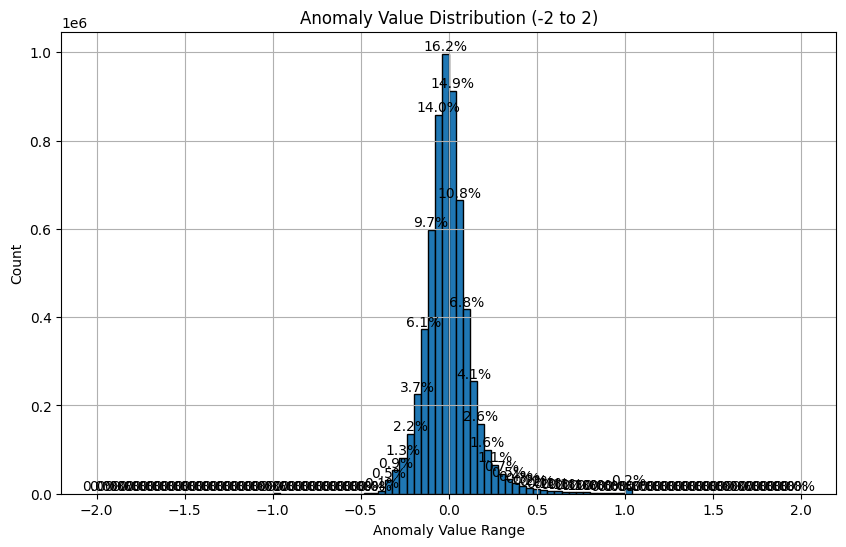

In [25]:
utils.plot_anomaly_distribution(new_anomaly, -2, 2, 100)

In [55]:
new_anomaly = np.clip(anomaly/5, -1, 1)

In [11]:
new_anomaly = anomaly

In [6]:
print(new_anomaly.min())
print(new_anomaly.max())
print(new_anomaly.mean())
print(new_anomaly.std())


-1.0
1.0
-0.0009162747
0.1454363


In [5]:
def min_max_normalize_channels_4D(lr_data):
    # 计算每个通道的最小值和最大值，忽略时间和经度维度
    channel_mins = torch.amin(lr_data, dim=(0, 2, 3), keepdim=True)
    channel_maxs = torch.amax(lr_data, dim=(0, 2, 3), keepdim=True)

    normalized_data = 2 * (lr_data - channel_mins) / (channel_maxs - channel_mins) - 1
    
    return normalized_data


lr_data = min_max_normalize_channels_4D(lr_data)

In [ ]:
def min_max_normalize_channels_5D(lr_data):
    # 计算每个通道的最小值和最大值，忽略时间、纬度、高度和经度维度
    channel_mins = torch.amin(lr_data, dim=(0, 2, 3, 4), keepdim=True)
    channel_maxs = torch.amax(lr_data, dim=(0, 2, 3, 4), keepdim=True)

    normalized_data = 2 * (lr_data - channel_mins) / (channel_maxs - channel_mins) - 1
    
    return normalized_data


lr_data = min_max_normalize_channels_5D(lr_data)

In [5]:
print(anomaly.unsqueeze(1).shape)

torch.Size([366, 1, 6, 120, 140])


In [6]:
lr_data[:, 0, :, :] = new_anomaly

In [8]:
np.save(os.path.join(config.modelconfig['lr_path'], 'lr_data_lead0_f1.npy'), lr_data)

In [11]:
np.save('E:/D1/diffusion/my_models/my_model_data/mod_all.npy', anomaly)

In [ ]:
for i in range(300):
    print(np.sum(normalized_data[i,0] < 0)/normalized_data[i,0].size)

In [30]:
# 读取原来的那个数据看看那个是怎么归一化的
original_data = torch.tensor(np.load(os.path.join(config.modelconfig["lr_path"], "lr_data1.npy")), dtype=torch.float32)
now_data = torch.tensor(np.load(os.path.join(config.modelconfig["lr_path"], "lr_data_lead0_2.npy")), dtype=torch.float32)


In [34]:
for i in range(min(original_data.shape[0], now_data.shape[0])):
    print(i)
    print(utils.cal_acc(original_data[i, :, :, :], now_data[i, :, :, :]))


0
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
2
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
3
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
4
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
5
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
6
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
7
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
8
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
9
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
10
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
11
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
12
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
13
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
14
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
15
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
16
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
17
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
18
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
19
tensor([1., 1., 1.,

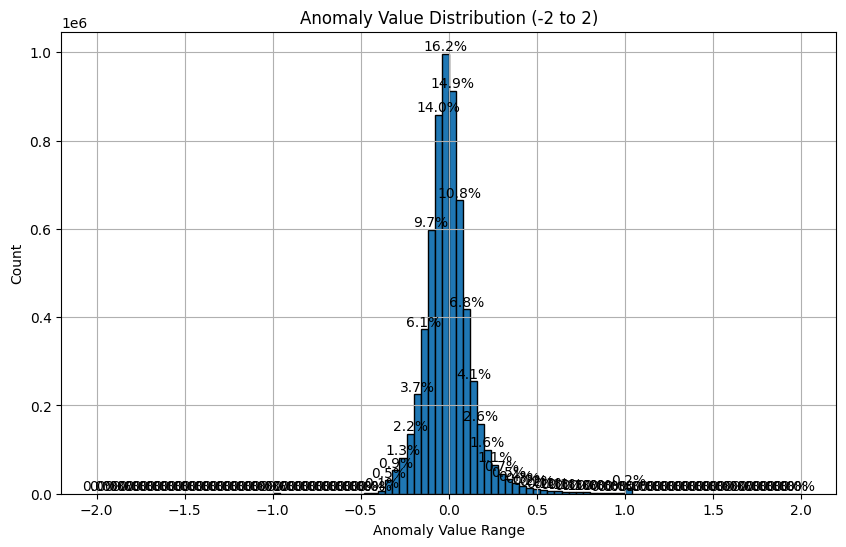

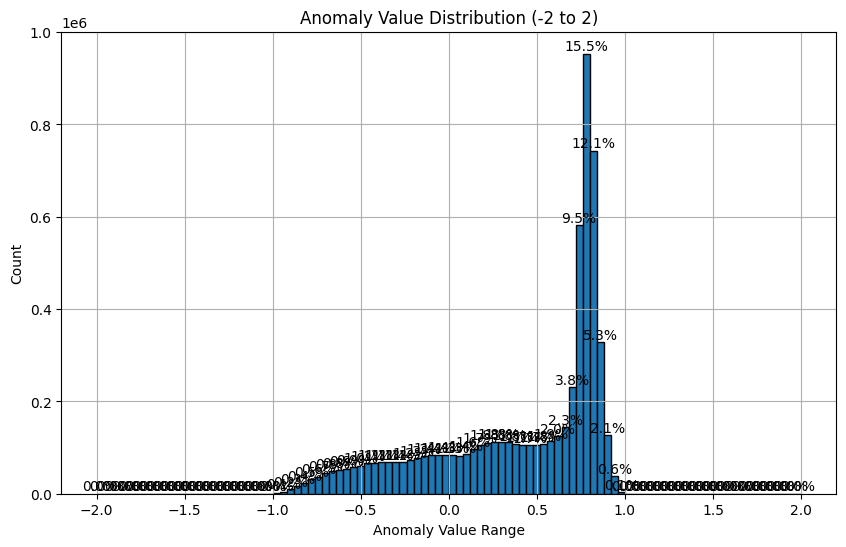

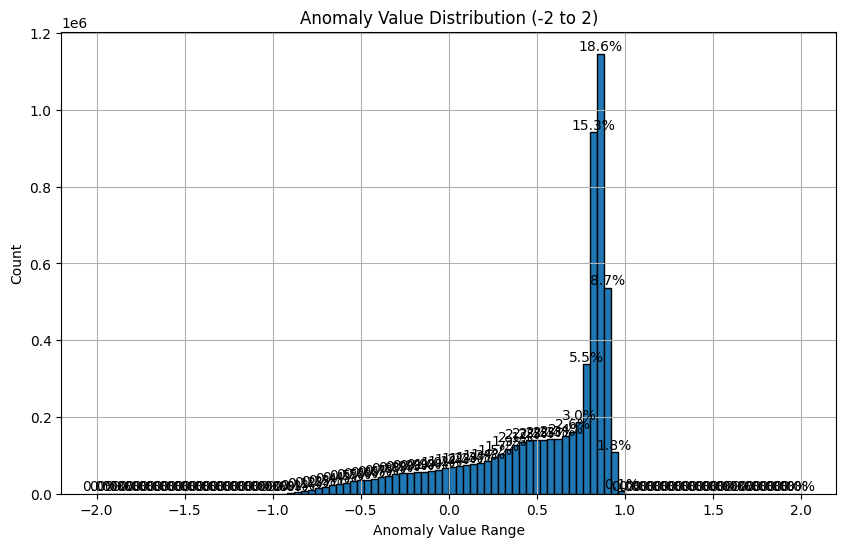

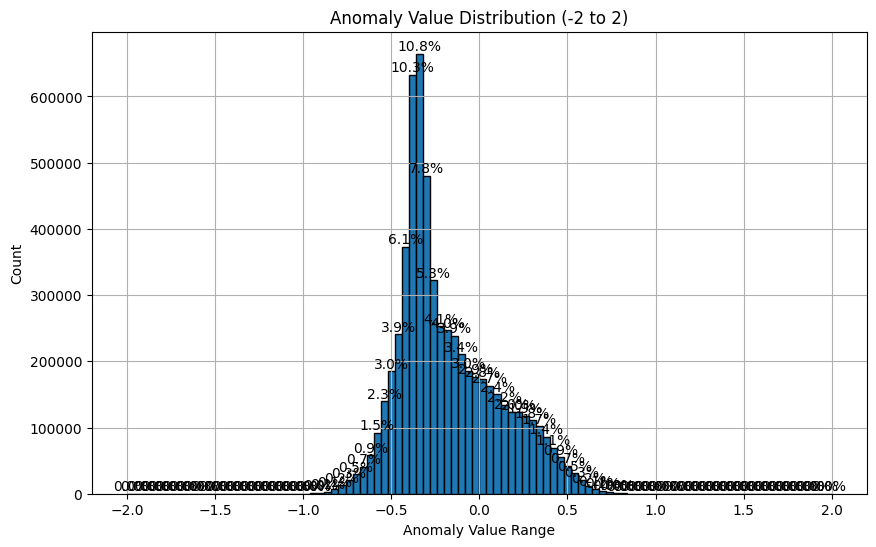

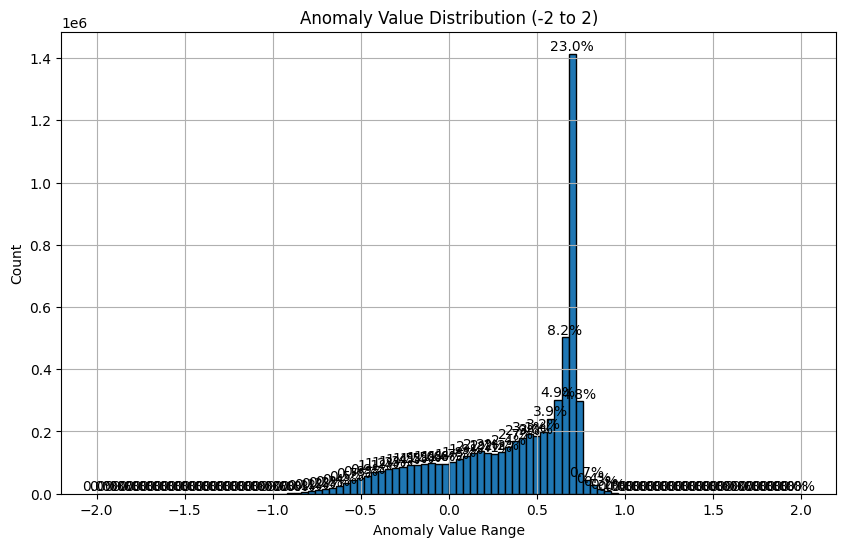

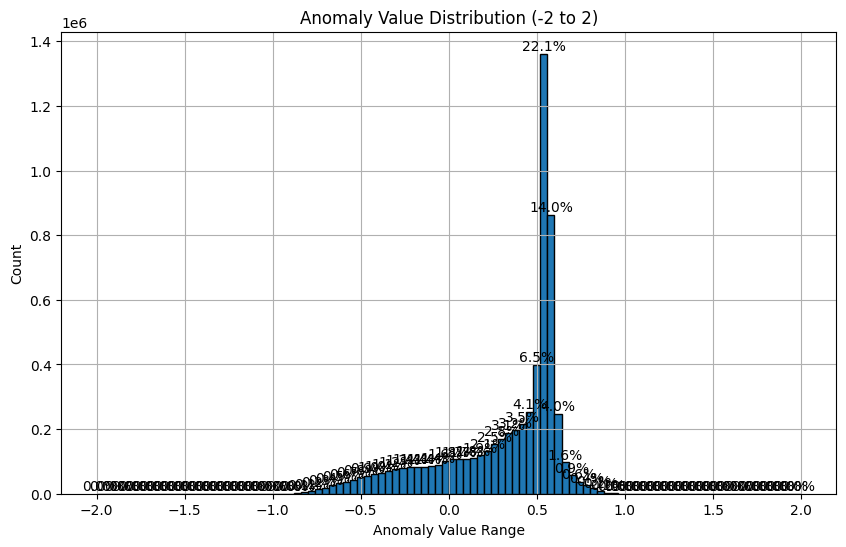

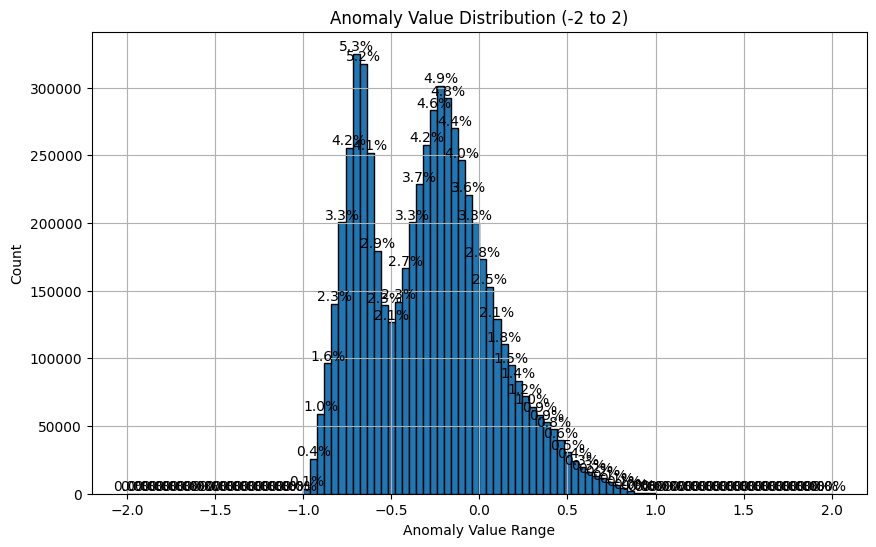

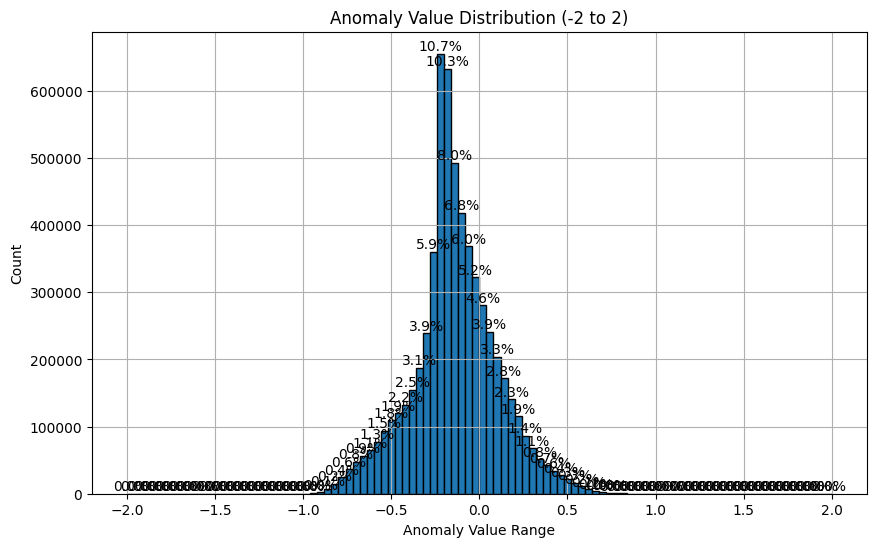

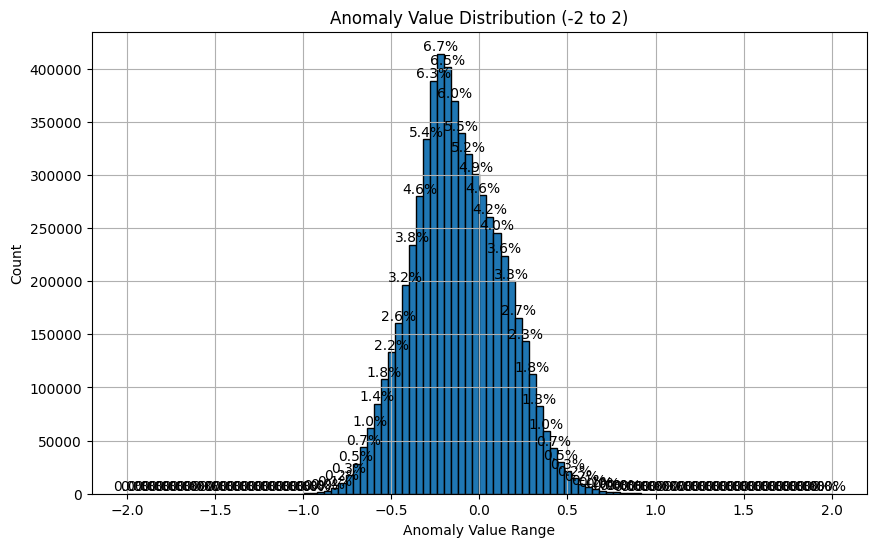

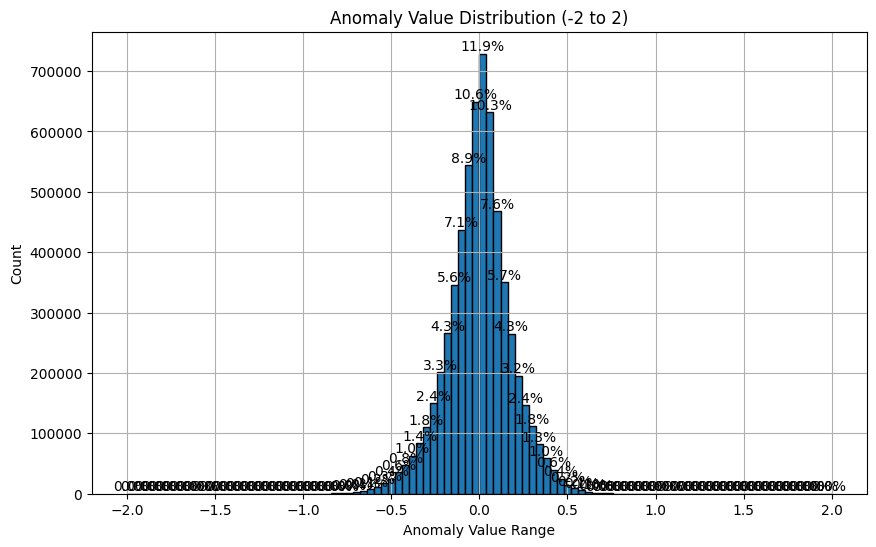

In [28]:
for i in range(lr_data.shape[1]):
    utils.plot_anomaly_distribution(lr_data[:,i], -2, 2, 100)

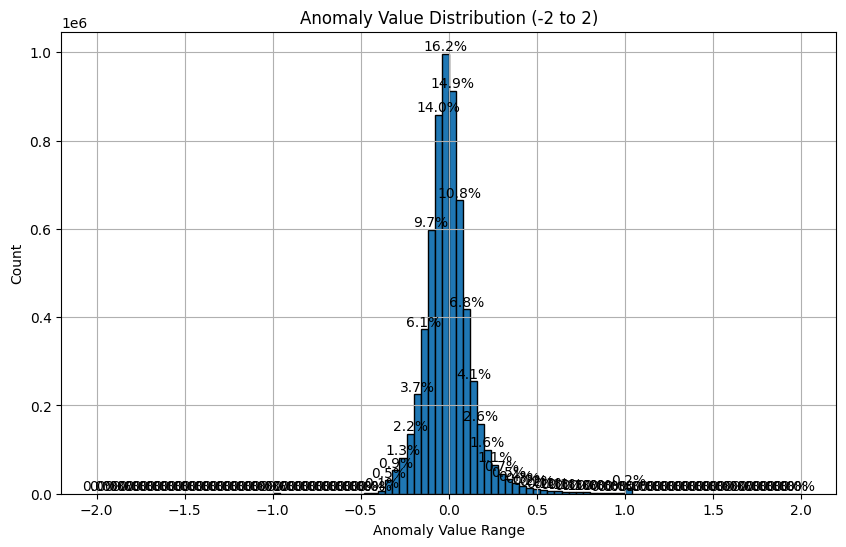

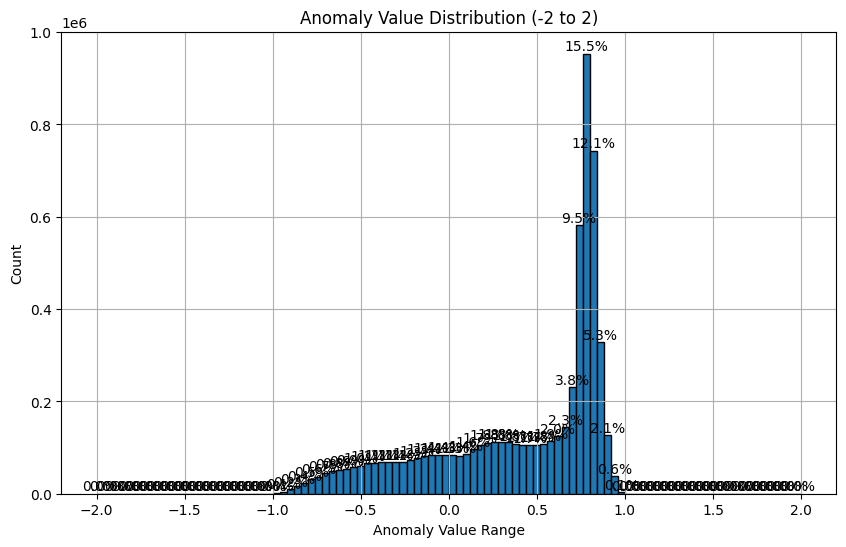

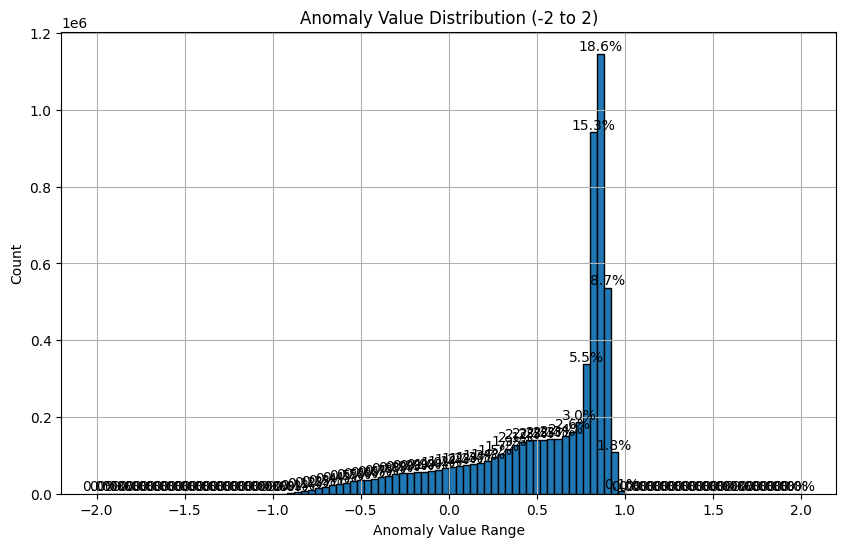

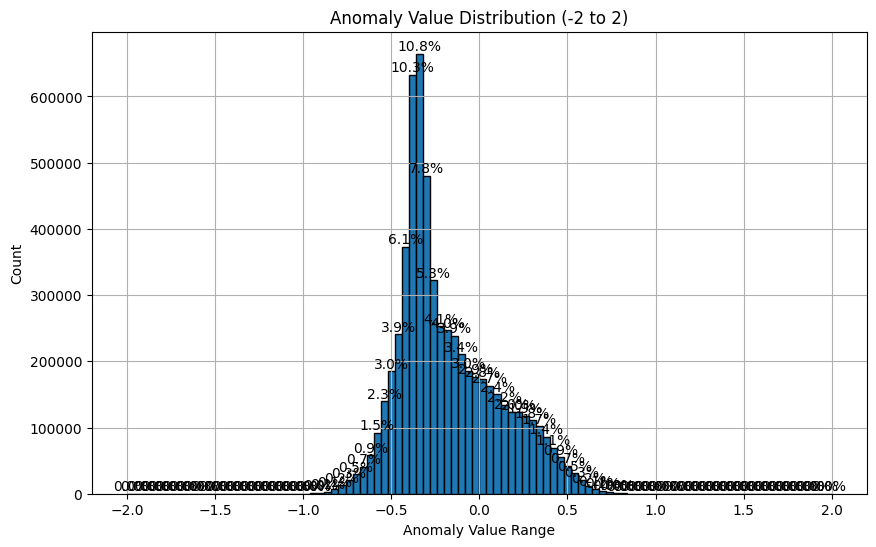

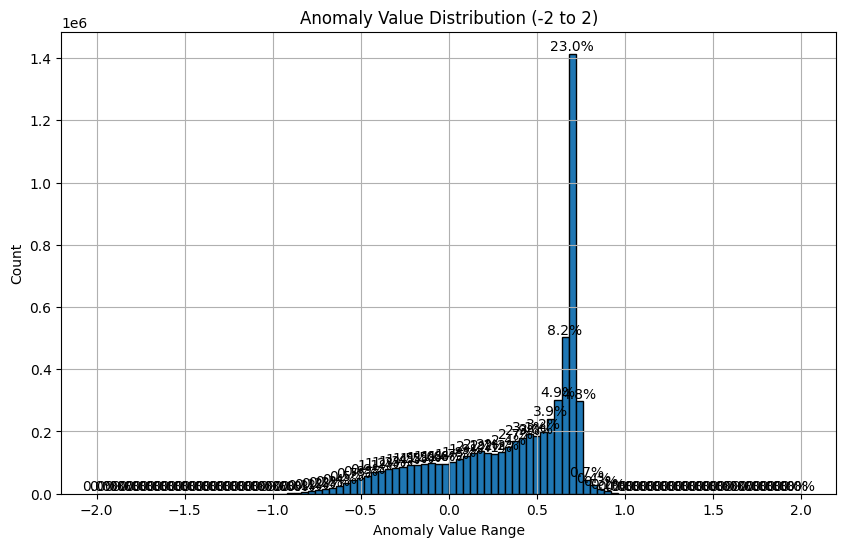

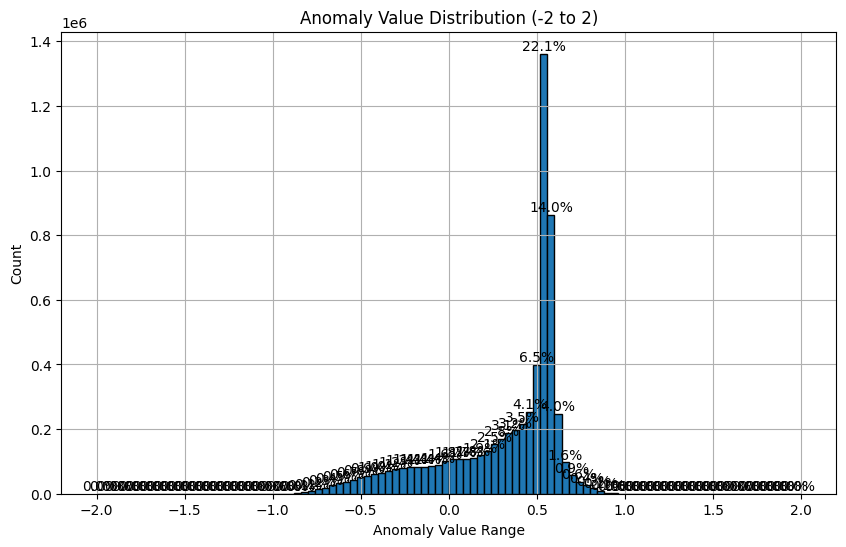

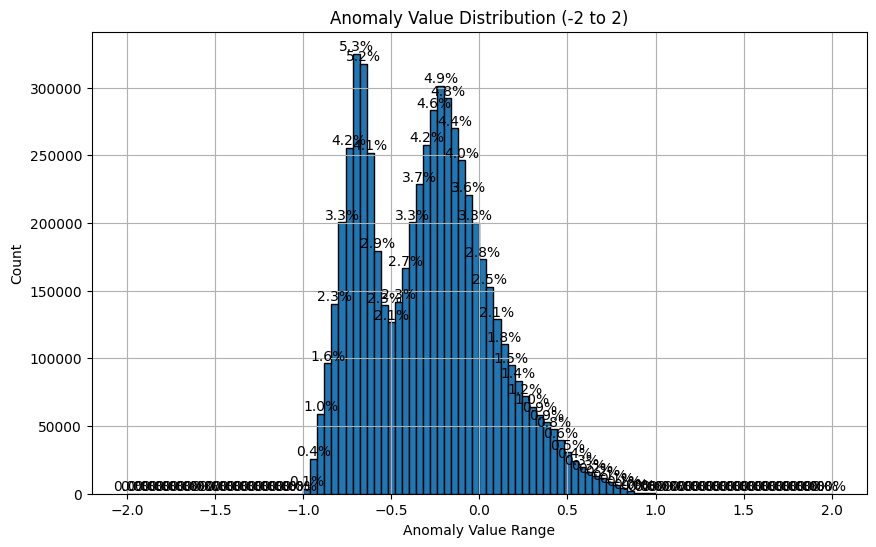

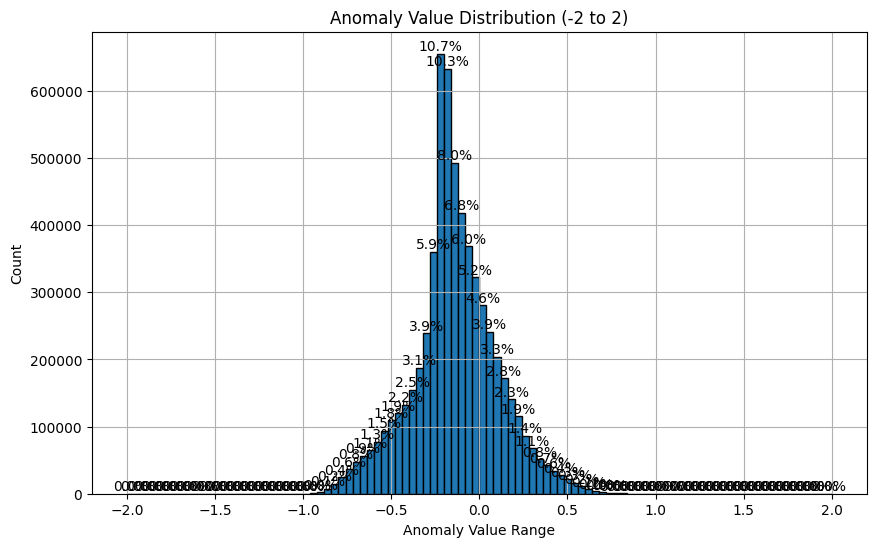

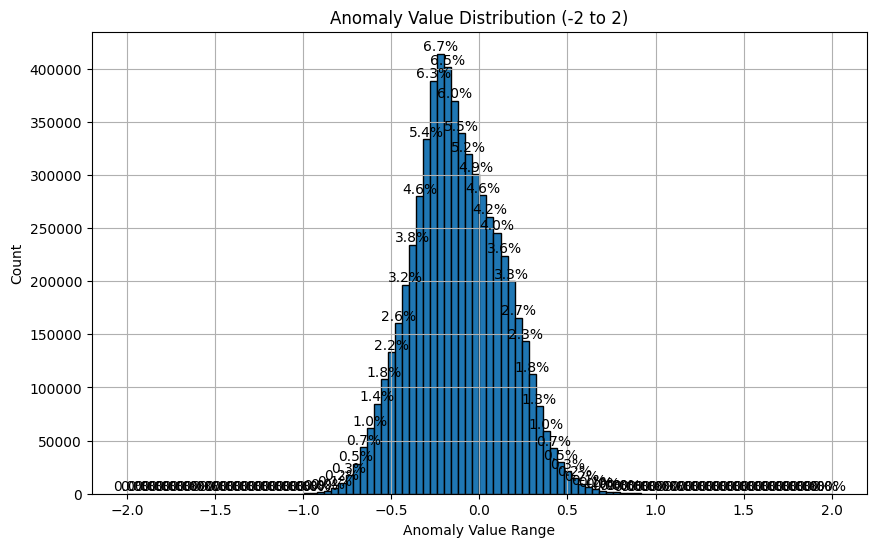

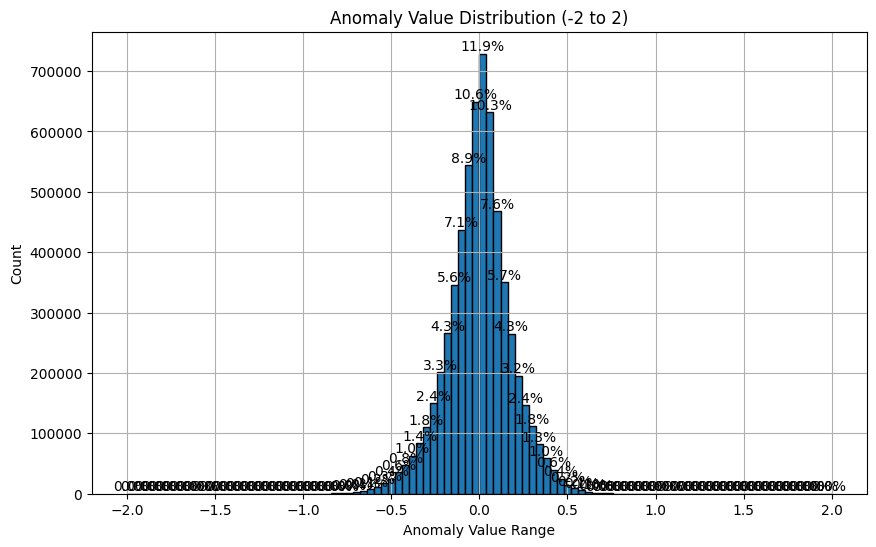

In [22]:
for i in range(original_data.shape[1]):
    utils.plot_anomaly_distribution(original_data[:,i], -2, 2, 100)

### 下面是分布情况

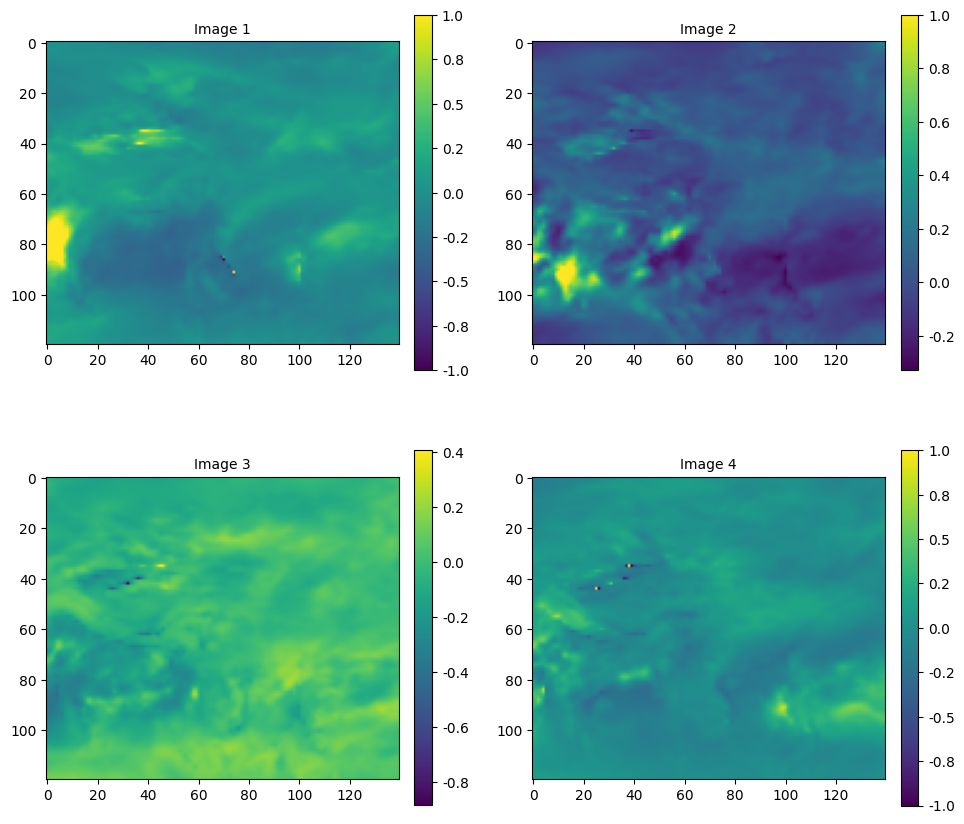

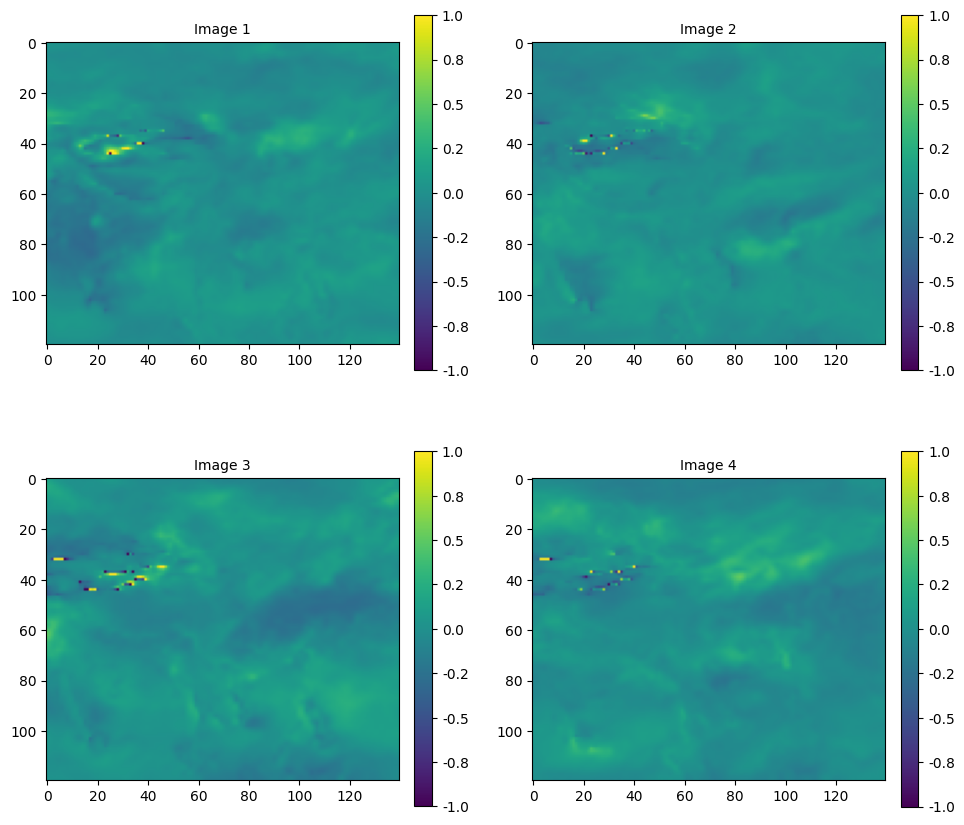

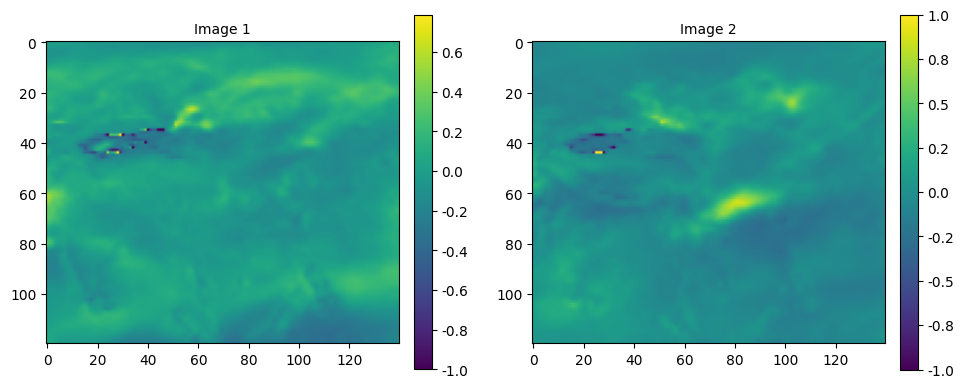

In [10]:

# nth_image = torch.tensor(normalized_data)[65]
nth_image = torch.tensor(new_anomaly)
save_image(nth_image[0], nth_image[1], nth_image[2], nth_image[3], show=True)
save_image(nth_image[4], nth_image[5], nth_image[6], nth_image[7], show=True)
save_image(nth_image[8], nth_image[9], show=True)

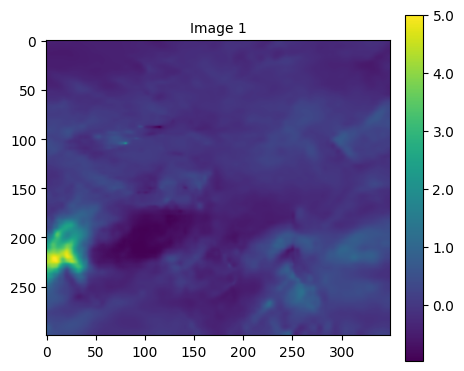

In [5]:
save_image(torch.tensor(anomaly_selected[0]), show=True)

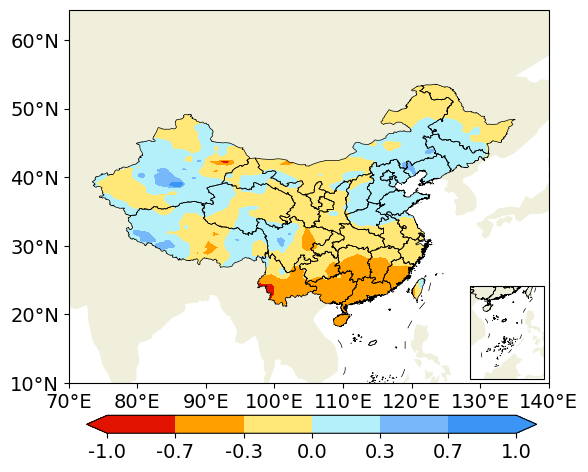

In [ ]:
utils.draw_rainfall_map(anomaly_selected[0], min=-1, max=1)

In [8]:

size_per_image = 32
save_path = 'E:\D1\diffusion\my_models\my_model_data\lr_images/'

x_list = np.arange(0, 350-size_per_image, 16)
y_list = np.arange(0, 300-size_per_image, 16)
for y_id, y in enumerate(y_list):
    for x_id, x in enumerate(x_list):
        sub_image = lr_data[0:345, :, y:y+size_per_image, x:x+size_per_image]
        np.save(save_path+str(x_id)+'_'+str(y_id)+'.npy', sub_image)


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\fired\AppData\Local\Temp\ipykernel_57196\2483321640.py:2: SyntaxWarning: invalid escape sequence '\D'
  save_path = 'E:\D1\diffusion\my_models\my_model_data\lr_images/'
